In [1]:
import os
import sys
import gensim
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

ROOT = os.path.dirname(os.getcwd())
#path_data = os.path.join(ROOT, 'data')
path_data = 'C:\\Users\\joris\\Documents\\eScience_data\\data'
sys.path.insert(0, ROOT)
sys.path.insert(0, "C:\\Users\\joris\\Documents\\eScience_data\\spec2vec_gnps_data_analysis\\custom_functions")

### Import pre-processed dataset "AllPositive"

In [2]:
import time
import pickle

#loading data as pickled object goes a lot quicker
outfile = os.path.join(path_data, 'gnps_positive_ionmode_cleaned_by_matchms_and_lookups.pickle')

print(outfile)
start = time.time()
with open(outfile, 'rb') as inf:
        spectrums = pickle.load(inf)
end = time.time()
print('loading took {:.2f} s'.format(end-start))

C:\Users\joris\Documents\eScience_data\data\gnps_positive_ionmode_cleaned_by_matchms_and_lookups.pickle
loading took 11.15 s


### Import spec2vec matches of 1,000 spectra where their inchikeys occur >=5 times in the library

In [3]:
import pickle
outfile = os.path.join(path_data, 'found_matches_s2v.pickle')
print(outfile)
if os.path.exists(outfile):
    with open(outfile, 'rb') as inf:
        found_matches_s2v = pickle.load(inf)
else:
    print('error')
    
#contains info on the query/library
outfile = os.path.join(path_data, 'documents_query_s2v.pickle')
print(outfile)
if os.path.exists(outfile):
    with open(outfile, 'rb') as inf:
        documents_query_s2v = pickle.load(inf)

outfile = os.path.join(path_data, 'documents_library_s2v.pickle')
print(outfile)
if os.path.exists(outfile):
    with open(outfile, 'rb') as inf:
        documents_library_s2v = pickle.load(inf)

C:\Users\joris\Documents\eScience_data\data\found_matches_s2v.pickle
C:\Users\joris\Documents\eScience_data\data\documents_query_s2v.pickle
C:\Users\joris\Documents\eScience_data\data\documents_library_s2v.pickle


### Calculate pairwise tanimoto similarity between top 20 results for each query

In [77]:
import pickle
from rdkit import Chem, DataStructs

outfile = os.path.join(path_data, 'similarity_matrices_test_set1.pickle')
print(outfile)
if os.path.exists(outfile):
    with open(outfile, 'rb') as inf:
        similarity_matrices = pickle.load(inf)
else:
    #for each matches df make a similarity matrix based on tanimoto
    similarity_matrices = []
    topn = 20

    for ID in range(len(found_matches_s2v)):
        df = found_matches_s2v[ID].sort_values(by=['s2v_score'], ascending = False).iloc[:topn]
        library_ids = df.index.values
        rows = []
        for lib_id_i in library_ids:
            smiles_i = documents_library_s2v[lib_id_i]._obj.get("smiles")

            if not smiles_i or smiles_i == "None": # check that lib_id_i smiles exist
                rows.append([0] * len(library_ids)) #default to all 0 if it doesnt exist
                continue
            ms_i = Chem.MolFromSmiles(smiles_i)
            if not ms_i: #in case something is wrong with smiles
                rows.append([0] * len(library_ids)) #default to all 0 if it doesnt exist
                continue
            fp_i = Chem.RDKFingerprint(ms_i)

            row = []
            for lib_id_j in library_ids:
                smiles_j = documents_library_s2v[lib_id_j]._obj.get("smiles")

                if smiles_j and smiles_j != "None":
                    ms_j = Chem.MolFromSmiles(smiles_j)
                    if ms_j:
                        fp_j = Chem.RDKFingerprint(ms_j)
                        score = DataStructs.FingerprintSimilarity(fp_i, fp_j)
                    else: #in case something is wrong with smiles
                        score = 0
                else: #in case it doesnt have smiles
                    score = 0
                row.append(score)

            rows.append(row)
        similarity_matrices.append(pd.DataFrame(rows))
    #write to file    
    with open(outfile, 'wb') as outf:
        pickle.dump(similarity_matrices, outf)

C:\Users\joris\Documents\eScience_data\data\similarity_matrices_test_set1.pickle


In [97]:
#corrected version where true matches get a slightly higher value in the diagonal
import pickle
cor_val = 1.001
outfile = os.path.join(path_data, 'similarity_matrices_corrected_test_set1.pickle')
print(outfile)
if os.path.exists(outfile):
    with open(outfile, 'rb') as inf:
        similarity_matrices_cor = pickle.load(inf)
else:
    #for each matches df make a similarity matrix based on tanimoto
    similarity_matrices_cor = []
    topn = 20

    for ID in range(len(found_matches_s2v)):
        df = found_matches_s2v[ID].sort_values(by=['s2v_score'], ascending = False).iloc[:topn]
        library_ids = df.index.values
        rows = []
        for lib_id_i in library_ids:
            smiles_i = documents_library_s2v[lib_id_i]._obj.get("smiles")

            if not smiles_i or smiles_i == "None": # check that lib_id_i smiles exist
                rows.append([0] * len(library_ids)) #default to all 0 if it doesnt exist
                continue
            ms_i = Chem.MolFromSmiles(smiles_i)
            if not ms_i: #in case something is wrong with smiles
                rows.append([0] * len(library_ids)) #default to all 0 if it doesnt exist
                continue
            fp_i = Chem.RDKFingerprint(ms_i)

            row = []
            for lib_id_j in library_ids:
                if lib_id_i == lib_id_j: #if diagonal see if its a true match and give it a slightly higher value for plotting
                    df_select = found_matches_s2v_match_perc_pmass_sim[ID].sort_values(by=['s2v_score'], ascending = False).iloc[:topn]
                    if df_select.loc[lib_id_j]['label'] == 1:
                        score = cor_val
                    else:
                        score = 1
                    
                else:
                    smiles_j = documents_library_s2v[lib_id_j]._obj.get("smiles")

                    if smiles_j and smiles_j != "None":
                        ms_j = Chem.MolFromSmiles(smiles_j)
                        if ms_j:
                            fp_j = Chem.RDKFingerprint(ms_j)
                            score = DataStructs.FingerprintSimilarity(fp_i, fp_j)
                        else: #in case something is wrong with smiles
                            score = 0
                    else: #in case it doesnt have smiles
                        score = 0
                row.append(score)

            rows.append(row)
        similarity_matrices_cor.append(pd.DataFrame(rows))
    #write to file
    with open(outfile, 'wb') as outf:
        pickle.dump(similarity_matrices_cor, outf)

C:\Users\joris\Documents\eScience_data\data\similarity_matrices_corrected_test_set1.pickle


In [96]:
df_select = found_matches_s2v_match_perc_pmass_sim[999].sort_values(by=['s2v_score'], ascending = False).iloc[:20]
true_positives = [i for i, lab in enumerate(df_select['label']) if lab == 1]
df_select.loc[lib_id_j]['label']

0.0

In [139]:
df_rows = similarity_matrices_cor[12]
df_rows

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,1.001000,1.000000,1.000000,0.943409,0.943409,1.000000,0.943409,0.943409,1.000000,0.793333,0.943409,0.943409,0.694184,0.662455,0.694184,0.638623,0.694184,0.638623,0.694184,0.647243
1,1.000000,1.001000,1.000000,0.943409,0.943409,1.000000,0.943409,0.943409,1.000000,0.793333,0.943409,0.943409,0.694184,0.662455,0.694184,0.638623,0.694184,0.638623,0.694184,0.647243
2,1.000000,1.000000,1.001000,0.943409,0.943409,1.000000,0.943409,0.943409,1.000000,0.793333,0.943409,0.943409,0.694184,0.662455,0.694184,0.638623,0.694184,0.638623,0.694184,0.647243
3,0.943409,0.943409,0.943409,1.000000,1.000000,0.943409,1.000000,1.000000,0.943409,0.756724,1.000000,1.000000,0.719528,0.665423,0.719528,0.661765,0.719528,0.661765,0.719528,0.666012
4,0.943409,0.943409,0.943409,1.000000,1.000000,0.943409,1.000000,1.000000,0.943409,0.756724,1.000000,1.000000,0.719528,0.665423,0.719528,0.661765,0.719528,0.661765,0.719528,0.666012
5,1.000000,1.000000,1.000000,0.943409,0.943409,1.001000,0.943409,0.943409,1.000000,0.793333,0.943409,0.943409,0.694184,0.662455,0.694184,0.638623,0.694184,0.638623,0.694184,0.647243
6,0.943409,0.943409,0.943409,1.000000,1.000000,0.943409,1.000000,1.000000,0.943409,0.756724,1.000000,1.000000,0.719528,0.665423,0.719528,0.661765,0.719528,0.661765,0.719528,0.666012
7,0.943409,0.943409,0.943409,1.000000,1.000000,0.943409,1.000000,1.000000,0.943409,0.756724,1.000000,1.000000,0.719528,0.665423,0.719528,0.661765,0.719528,0.661765,0.719528,0.666012
8,1.000000,1.000000,1.000000,0.943409,0.943409,1.000000,0.943409,0.943409,1.001000,0.793333,0.943409,0.943409,0.694184,0.662455,0.694184,0.638623,0.694184,0.638623,0.694184,0.647243
9,0.793333,0.793333,0.793333,0.756724,0.756724,0.793333,0.756724,0.756724,0.793333,1.000000,0.756724,0.756724,0.661884,0.684015,0.661884,0.676178,0.661884,0.676178,0.661884,0.680104


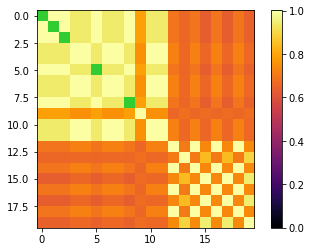

In [142]:
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap

x = 100000
inferno = cm.get_cmap('inferno', x)
green = np.array([50/256, 205/256, 50/256, 1])
new_colours = np.vstack((inferno(np.linspace(0, 1, x)), green))
new_cmap = ListedColormap(new_colours, name='inferno-green')
plt.imshow(df_rows, cmap=new_cmap, vmin=0, vmax=cor_val)
plt.colorbar()
plt.show()

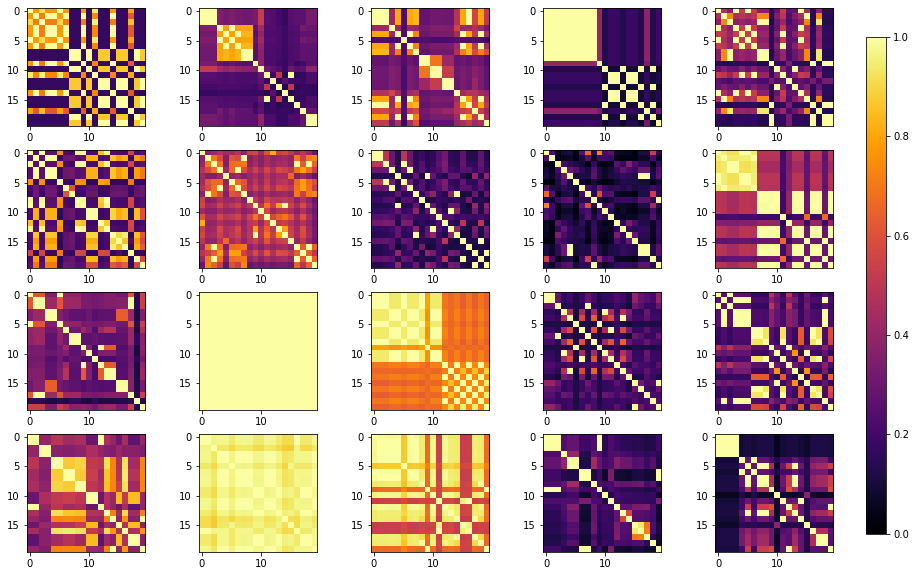

In [132]:
fig, axs = plt.subplots(4, 5, figsize=(14,10))
for i, ax in enumerate(axs.flat):
    im = ax.imshow(similarity_matrices[i], cmap='inferno', vmin = 0, vmax = 1)

fig.subplots_adjust(right=0.95)
cbar_ax = fig.add_axes([0.97, 0.15, 0.02, 0.69])
fig.colorbar(im, cax=cbar_ax)

plt.show()

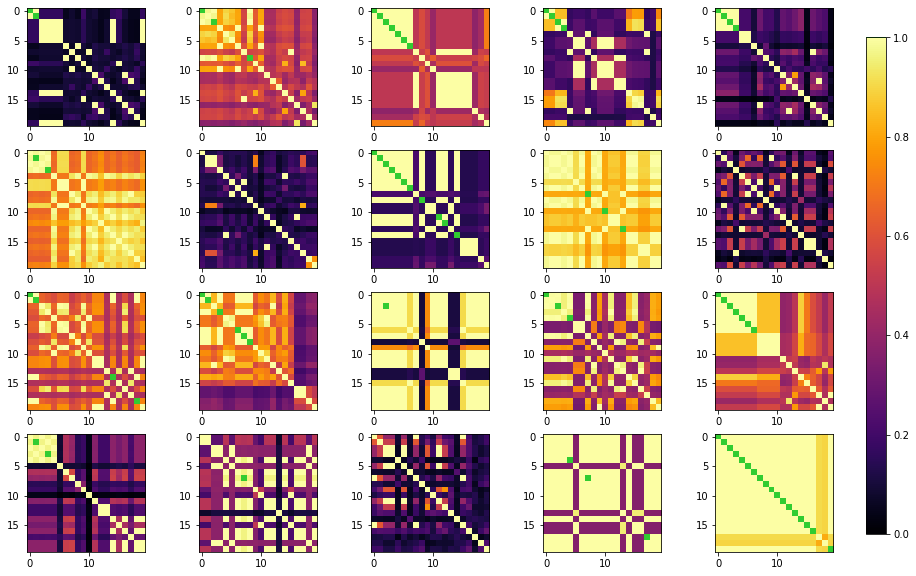

In [140]:
fig, axs = plt.subplots(4, 5, figsize=(14,10))
for i, ax in enumerate(axs.flat):
    im = ax.imshow(similarity_matrices_cor[i+80], cmap=new_cmap, vmax=cor_val, vmin=0)

fig.subplots_adjust(right=0.95)
cbar_ax = fig.add_axes([0.97, 0.15, 0.02, 0.69])
fig.colorbar(im, cax=cbar_ax)

plt.show()

In [9]:
outfile = os.path.join(path_data, 'rfreg_all_match_perc_pmass.pickle')
print(outfile)
if os.path.exists(outfile):
    with open(outfile, 'rb') as inf:
        rfreg_all_match_perc_pmass = pickle.load(inf)

outfile = os.path.join(path_data, 'found_matches_s2v_match_perc_pmass_sim.pickle')
print(outfile)
if os.path.exists(outfile):
    with open(outfile, 'rb') as inf:
        found_matches_s2v_match_perc_pmass_sim = pickle.load(inf)

C:\Users\joris\Documents\eScience_data\data\rfreg_all_match_perc_pmass.pickle
C:\Users\joris\Documents\eScience_data\data\found_matches_s2v_match_perc_pmass_sim.pickle


In [125]:
found_matches_s2v_match_perc_pmass_sim[11].sort_values(by=['s2v_score'], ascending = False).iloc[:20]

,cosine_score,cosine_matches,mod_cosine_score,mod_cosine_matches,mass_match,s2v_score,label,perc_mass_change,parent_mass,similarity
27686,0.755445,58,0.755445,58,1.0,0.893257,1,0.000000,839.713724,1.0
28318,0.865761,53,0.867084,49,0.0,0.881854,0,3.098199,813.697724,1.0
27952,0.720969,44,0.809787,47,0.0,0.855725,0,1.429058,851.713724,1.0
28535,0.690283,46,0.791422,49,0.0,0.854305,0,1.429058,851.713724,1.0
28052,0.705840,47,0.794363,50,0.0,0.853600,0,1.429058,851.713724,1.0
27762,0.715044,45,0.815061,50,0.0,0.853507,0,1.429058,851.713724,1.0
27860,0.685362,47,0.783676,49,0.0,0.850866,0,1.429058,851.713724,1.0
27592,0.723186,44,0.824784,48,0.0,0.848457,0,1.429058,851.713724,1.0
28427,0.754778,35,0.849043,36,0.0,0.845511,0,1.429058,851.713724,1.0
28063,0.729944,46,0.821624,50,0.0,0.838165,0,3.338161,867.744724,1.0


In [11]:
#visualise tanimoto score of query vs match per position
topn = 20
all_similarities = []
for ID in range(len(found_matches_s2v_match_perc_pmass_sim)):
    df_select = found_matches_s2v_match_perc_pmass_sim[ID].sort_values(by=['s2v_score'], ascending = False).iloc[:topn]
    simil = df_select['similarity']
    all_similarities.append(list(simil))

In [12]:
per_pos = list(zip(*all_similarities))
#print(per_pos)
means = list(map(np.mean, per_pos))
stdevs = list(map(np.std, per_pos))

<BarContainer object of 20 artists>

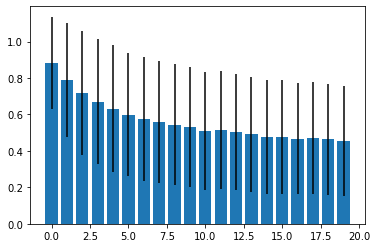

In [13]:
plt.bar(range(len(means)), means, yerr = stdevs)

In [138]:
#for each best true hit, how many connections > 0.6 does it have?
topn = 20
ID=0
cutoff = 0.6
amount_sims = []
for ID in range(len(found_matches_s2v_match_perc_pmass_sim)):
    df_select = found_matches_s2v_match_perc_pmass_sim[ID].sort_values(by=['s2v_score'], ascending = False).iloc[:topn]
    true_positives = [i for i, lab in enumerate(df_select['label']) if lab == 1]
    try:
        true_pos = true_positives[0] #take top hit
    except IndexError:
        amount_sim = -1 #true positive can't be found in topn
    else:
        amount_sim = len(similarity_matrices[ID][similarity_matrices[ID][true_pos] > cutoff])
    #report max cases
    #if amount_sim == 20:
        #print(ID)
    amount_sims.append(amount_sim)

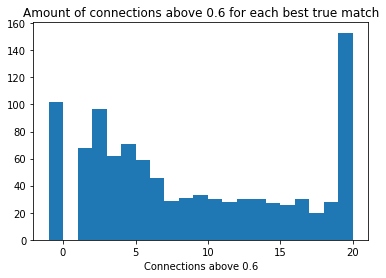

In [110]:
plt.hist(amount_sims, bins = range(-1, max(amount_sims)+1))
plt.xlabel('Connections above 0.6')
plt.title('Amount of connections above 0.6 for each best true match')
plt.show()